# Approach

* This is a simplied version of YOLO. We take our 512x512 input, divide it into a 16x16 grid, each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
* For labels we have assigned each box to the cell which is in it's center and have assigned the actual x, y, w, and h values to that cell.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* The network outputs a 16x16x1 array of confidences and a 16x16x4 array of bounding boxes.
* The confidence cells have a sigmoid activation, the bboxes are linear.
* We use a binary cross entropy loss for the confidence and mean squared error for the bounding boxes.

# Predictions
* To generate our predictions we loop through each cell of the output, if the confidence is greater than 0.5 we append the corresponding bounding box to the prediction string. 

**Note:** Since each pixel only outputs one bounding box there is currently no non-max suppression. We can add this later if neccessary.

**Change Log:**
* v2 - adding extra 1x1 convs for each output; changed loss weights to weight xe loss a bit higher; working on IOU metric function

In [15]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [41]:
pred = np.array([ [150, 200, 200, 500], [0, 0, 0, 0], [100, 200, 300, 400]] )
truth = np.array([ [177, 285, 225, 529], [641, 473, 201, 309], [0, 0, 0, 0]] )
print("pred:", pred.shape)

x11, y11, w1, h1 = pred[:,0], pred[:,1], pred[:,2], pred[:,3]
x21, y21, w2, h2 = truth[:,0], truth[:,1], truth[:,2], truth[:,3]

x12 = x11 + w1
y12 = y11 + h1

x22 = x21 + w2
y22 = y21 + h2

print("x12:", x12)
print("y12:", y12)
print("x22:", x22)
print("y22:", y22)

xI1 = np.maximum(x11, x21)
yI1 = np.maximum(y11, y21)
print("xI1:", xI1, "yI1:", yI1)

xI2 = np.minimum(x12, x22)
yI2 = np.minimum(y12, y22)
print("xI2:", xI2, "yI2:", yI2)

bboxes1_area = (w1 + 1) * (h1 + 1)
bboxes2_area = (w2 + 1) * (h2 + 1)
truth_exists = w2 * h2 > 0
print("truth?", truth_exists)
print("bboxes1_area:", bboxes1_area)
print("bboxes2_area:", bboxes2_area)

inter_area = truth_exists * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)
print("inter:", inter_area)

union = (bboxes1_area + np.transpose(bboxes2_area)) - inter_area
print("union:", union)

iou = np.maximum(inter_area / union, 0)
print("iou:", iou)

pred: (3, 4)
x12: [350   0 400]
y12: [700   0 600]
x22: [402 842   0]
y22: [814 782   0]
xI1: [177 641 100] yI1: [285 473 200]
xI2: [350   0   0] yI2: [700   0   0]
truth? [ True  True False]
bboxes1_area: [100701      1 120701]
bboxes2_area: [119780  62620      1]
inter: [ 72384 302080      0]
union: [ 148097 -239459  120702]
iou: [0.48876074 0.         0.        ]


In [43]:
0 / 1

0.0

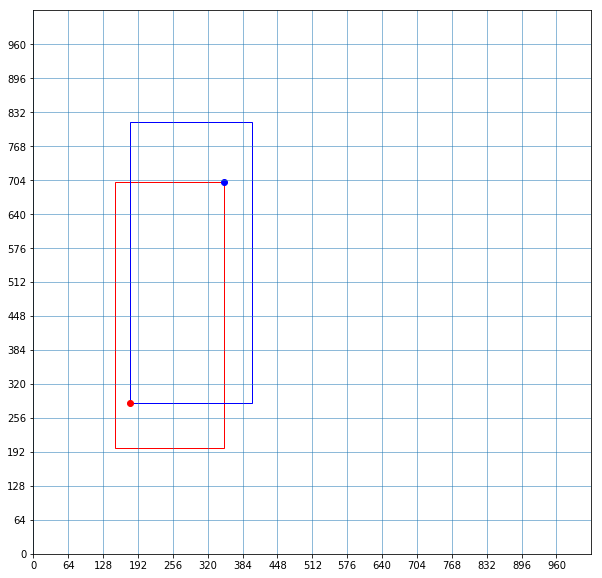

In [25]:
coords = np.arange(0, 1024, 64)

fig,ax = plt.subplots(1, figsize=(10,10))

rect_1 = patches.Rectangle((150,200),200,500,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(177, 285, marker="o", color="r")
rect_2 = patches.Rectangle((177,285),225,529,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(350, 700, marker="o", color="b")
ax.add_patch(rect_1)
ax.add_patch(rect_2)
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

In [14]:
pred = tf.placeholder(shape=(None, 16, 16, 4), dtype=tf.int32)
truth = tf.placeholder(shape=(None, 16, 16, 4), dtype=tf.int32)

pred = tf.reshape(pred, (-1, 4))
truth = tf.reshape(truth, (-1, 4))

print("pred:", pred.shape)
print("truth:", truth.shape)

x11, y11, w1, h1 = tf.split(pred, 4, axis=1)
x21, y21, w2, h2 = tf.split(truth, 4, axis=1)

print("x11:", x11.shape)
print("x21:", x21.shape)

x12 = x11 + w1
y12 = y11 + h1

x22 = x21 + w2
y22 = y21 + h2

print("x12:", x12.shape)
print("y12:", y12.shape)

xI1 = tf.maximum(x11, tf.transpose(x21))
yI1 = tf.maximum(y11, tf.transpose(y21))

xI2 = tf.minimum(x12, tf.transpose(x22))
yI2 = tf.minimum(y12, tf.transpose(y22))

inter_area = (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

bboxes1_area = (w1 + 1) * (h1 + 1)
bboxes2_area = (w2 + 1) * (h2 + 1)

union = (bboxes1_area + tf.transpose(bboxes2_area)) - inter_area

print("union:", union.shape)

iou = tf.reduce_mean(tf.maximum(inter_area / union, 0))
print("iou:", iou.shape)

pred: (?, 4)
truth: (?, 4)
x11: (?, 1)
x21: (?, 1)
x12: (?, 1)
y12: (?, 1)
union: (?, ?)
iou: ()


In [2]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [3]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [46]:
with open('yolo_labels.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [105]:
foo = pneumonia_locations["fffb2395-8edd-4954-8a89-ffe2fd329be3"]
boxes = foo[:,:,1:]
boxes[0,0,:] = 5, 10, 20, 20
mask = boxes[:,:,0] > 0
boxes[mask, 0] = 100 - boxes[mask,0]
flipped = np.flip(boxes, axis=0)


In [106]:
flipped

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]],

       [[95.

In [102]:
boxes[mask, 0]

array([  5., 177., 641.])

# Load filenames

In [5]:
random.seed(72)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [44]:
BATCH_SIZE = 12
IMAGE_SIZE = 512
CHECKPOINT_PATH = "yolo1_512.h5"

In [45]:
foo = np.array([ [1, 0, 0], [0, 1, 0], [0, 0, 1]])
np.fliplr(foo)

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

In [128]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## data augmentation may be complicated, let's do that later
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = boxes[:,:,0] > 0
            boxes[mask, 0] = 1024 - boxes[mask,0]
            
            # flip our boxes lr
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confs lr
            confs = np.flip(confs, axis=0)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')

        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, confs, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, confs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            confs = np.expand_dims(np.array(confs), -1)
            bboxes = np.array(bboxes)
            
            labels = {"confidence_output": confs, "bboxes_output": bboxes}
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [143]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
#     x = keras.layers.Conv2D(channels, (3,3), strides=(2,2), padding='same', use_bias=False)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0)(x)
    x_2 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x_2, inputs])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_2])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels*2, 1, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
            
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_c")(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_b")(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.25)(b)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation="sigmoid", name="confidence_output")(c)
    boxes = keras.layers.Conv2D(4, (1,1), padding='same', activation="linear", name="bboxes_output")(b)
    
    model = keras.Model(inputs=inputs, outputs=[confidence, boxes])
    
    return model

# Train network


In [3]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.4 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.6 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    mean_iou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    return mean_iou

def adj_mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true_pos = tf.reduce_max(y_true, axis=[1, 2, 3])
    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def weighted_binary_cross_entropy(y_true, y_pred):
    weight = 768
    weights = tf.multiply(tf.cast(weight, tf.float32), tf.cast(tf.greater(y_true, 0), tf.float32)) + 1
    xe = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels=y_true, logits=y_pred, weights=weights))
    
    return xe
    
def bbox_overlap_iou(bboxes1, bboxes2):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    
    bboxes1 = tf.reshape(bboxes1, (-1, 4))
    bboxes2 = tf.reshape(bboxes2, (-1, 4))
    
    x11, y11, w1, h1 = tf.split(bboxes1, 4, axis=1)
    x21, y21, w2, h2 = tf.split(bboxes2, 4, axis=1)
    
    x12 = x11 + w1
    y12 = y11 + h1
    
    x22 = x21 + w2
    y22 = y21 + h2
    
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    true_boxes = tf.cast(tf.greater(w2 * h2, 0), tf.float32)
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    union = (bboxes1_area + bboxes2_area) - inter_area + 1

    return tf.reduce_mean(tf.maximum(inter_area / union, 0))

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

losses = {
    "confidence_output": weighted_binary_cross_entropy,
    "bboxes_output": "mean_squared_error",
}
lossWeights = { "confidence_output": 10.0, "bboxes_output": 0.1 }

metrics_dict = {
    "confidence_output": 'accuracy',
    "bboxes_output": [bbox_overlap_iou],
#     "bboxes_output": bbox_overlap_iou,
}

model.compile(optimizer='adam',
              loss=losses,
              loss_weights=lossWeights,
              metrics=metrics_dict)

# cosine learning rate annealing
def cosine_annealing(x):
    lr0 = 0.002
    epochs_drop = 5
    drop = 0.85
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

NameError: name 'create_network' is not defined

In [ ]:
# model.load_weights(CHECKPOINT_PATH)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=5, shuffle=True, verbose=1)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/5
1925/1926 [============================>.] - ETA: 0s - loss: 69799.5480 - confidence_output_loss: 0.0128 - bboxes_output_loss: 69780.6510 - confidence_output_acc: 0.9983 - bboxes_output_acc: 0.4971
Epoch 00001: saving model to yolo1_512.h5
1926/1926 [==============================] - 1484s 770ms/step - loss: 69797.2420 - confidence_output_loss: 0.0128 - bboxes_output_loss: 69778.3446 - confidence_output_acc: 0.9983 - bboxes_output_acc: 0.4971 - val_loss: 64552.2993 - val_confidence_output_loss: 0.0110 - val_bboxes_output_loss: 64532.8702 - val_confidence_output_acc: 0.9987 - val_bboxes_output_acc: 4.3200e-04
Epoch 2/5
1431/1926 [=====================>........] - ETA: 5:31 - loss: 65738.6509 - confidence_output_loss: 0.0108 - bboxes_output_loss: 65718.8871 - confidence_output_acc: 0.9986 - bboxes_output_acc: 0.5007

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=15, shuffle=True, verbose=1, initial_epoch=5)

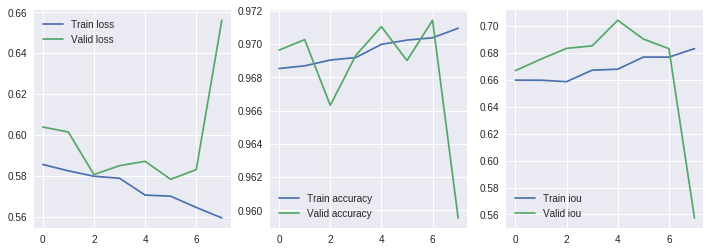

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

In [ ]:
THRESHOLD = 0.5
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=8, replace=False)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    # get boxes for the truth
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename]
        for i in range(16):
            for j in range(16):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0:
                    x, y, w, h = pixel_data[1:]
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    conf = np.squeeze(yhat[0])
    bboxes = np.squeeze(yhat[1])
    
    # loop through our predictions
    for i in range(16):
        for j in range(16):
            # if we have a prediction
            if conf[i,j] > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
    
    plt.show()

# Predict test images

In [24]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    conf_preds, bbox_preds = model.predict(imgs)
    
    # loop through batch
    for confs, bboxes, filename in zip(conf_preds, bbox_preds, filenames):
        predictionString = ""
        print(filename)
        for i in range(16):
            for j in range(16):
                conf = confs[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = bboxes[i,j]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        # cast to ints
                        x = int(x)
                        y = int(y)
                        w = int(w)
                        h = int(h)
                        
                        # make sure our boxes don't run off the edges of the images
                        w = np.minimum(w, 1024 - x)
                        h = np.minimum(h, 1024 - y)
                        
                        # create the prediction string
                        predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '

        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

n test samples: 1000
02743848-e50a-4faf-a3f4-a6215613a23d.dcm
2bd26d4b-b499-49e8-ad56-a20232b01af3.dcm
02ea47e2-e51d-4d4c-a2a2-41af99a91254.dcm


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "YOLO 512x512 10 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [20]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1GGJOHEa4uJTtlo-cvF2NLYjCbKp6hq3_
File ID: 1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ


{'id': '1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ'}

In [21]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./model7_448.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/93.8 MiB.                                     


In [19]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [20]:
!gsutil cp ./yolo_labels.p gs://{bucket_name}/

Copying file://./yolo_labels.p [Content-Type=text/x-pascal]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 403 Insufficient Permission
